In [8]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import json
import folium

sys.path.append('/lib')
import lib.helper as helper

%matplotlib inline
# %load_ext folium_magic

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
ANALYSES_DIR = "data/analyses/"
MAPS_DIR = DATA_DIR + "/maps"
UK_REGIONS_FILE = CURRENT_DIR + '/lib/UK-regions.json'

In [9]:
# Absolute or relative path to workshop data extracted from AMY
workshops_file = "data/processed/redash_processed_carpentry_workshops_UK_2020-04-09.csv"

In [10]:
workshops_df = pd.read_csv(workshops_file, encoding = "utf-8")

workshops_df.rename(columns={"venue": "institution"}, inplace=True)
# Add column 'description' which is used in popups in maps
workshops_df['popup'] = np.where(workshops_df["address"].empty, workshops_df["institution"],
                                               workshops_df["institution"] + ', ' + workshops_df["address"])

In [11]:
# Let's inspect our data
workshops_df.head(5)

,slug,year,start,end,attendance,country,region,country_code,organiser,organiser_web_domain,...,address,longitude,latitude,workshop_type,workshop_subtype,workshop_status,tags,website_url,workshop_domains,popup
0,2020-06-08-cambridge,2020.0,2020-06-08,2020-06-09,0,United Kingdom,NaN,GB,University of Cambridge,cam.ac.uk,...,NaN,NaN,NaN,LC,NaN,NaN,['LC'],NaN,NaN,NaN
1,2020-05-28-ttt-edinburgh,2020.0,2020-05-28,2020-05-29,0,United Kingdom,NaN,GB,SSI Software Sustainability Institute,software.ac.uk,...,NaN,NaN,NaN,TTT,NaN,NaN,"['TTT', 'online']",https://edcarp.github.io/2020-05-28-ttt-edinbu...,NaN,NaN
2,2020-05-20-swansea,2020.0,2020-05-20,2020-05-21,0,United Kingdom,Wales,GB,Swansea University,swansea.ac.uk,...,"Room 516, Vivian Tower, Swansea University, Si...",-3.982323,51.609054,SWC,NaN,NaN,['SWC'],https://sa2c.github.io/2020-05-20-swansea,NaN,"Singleton Campus, Swansea University, Room 516..."
3,2020-03-03-earlham,2020.0,2020-03-03,2020-03-04,0,United Kingdom,Eastern,GB,Earlham Institute,earlham.ac.uk,...,"Norwich Research Park, Norwich, NR4 7UZ UK",1.218976,52.621887,DC,NaN,NaN,['DC'],https://tgac.github.io/2020-03-03-earlham/,NaN,"Earlham Institute, Norwich Research Park, Norw..."
4,2020-02-25-cardiff,2020.0,2020-02-25,2020-02-26,0,United Kingdom,Wales,GB,Swansea University,swansea.ac.uk,...,"Mercure Hotel, Newport Road, Cardiff",-3.167152,51.483926,SWC,NaN,NaN,['SWC'],https://edbennett.github.io/2020-02-25-cardiff,NaN,"Cardiff, Mercure Hotel, Newport Road, Cardiff"


In [12]:
# Let's inspect our data
workshops_df.tail(5)

,slug,year,start,end,attendance,country,region,country_code,organiser,organiser_web_domain,...,address,longitude,latitude,workshop_type,workshop_subtype,workshop_status,tags,website_url,workshop_domains,popup
349,2018-11-xx-st-andrews-swc,NaN,NaN,NaN,0,United Kingdom,NaN,GB,University of St. Andrews,st-andrews.ac.uk,...,NaN,NaN,NaN,SWC,NaN,stalled,"['SWC', 'stalled']",NaN,['Psychology/neuroscience'],NaN
350,2018-09-xx-bradford-dc,NaN,NaN,NaN,0,United Kingdom,NaN,GB,University of Bradford,bradford.ac.uk,...,NaN,NaN,NaN,NaN,NaN,cancelled,['cancelled'],NaN,"['Chemistry', 'Organismal biology (ecology, bo...",NaN
351,2018-12-xx-sussex,NaN,NaN,NaN,0,NaN,NaN,NaN,University of Sussex,sussex.ac.uk,...,NaN,NaN,NaN,SWC,NaN,stalled,"['SWC', 'stalled']",NaN,"[""Don't know yet""]",NaN
352,2019-06-xx-location,NaN,NaN,NaN,0,United Kingdom,NaN,GB,SSI Software Sustainability Institute,software.ac.uk,...,NaN,NaN,NaN,LC,NaN,cancelled,"['LC', 'cancelled']",NaN,NaN,NaN
353,2020-xx-xx-cilip,NaN,NaN,NaN,0,United Kingdom,NaN,GB,"CILIP, library and information association",cilip.org.uk,...,NaN,NaN,NaN,LC,NaN,cancelled,"['LC', 'cancelled']",NaN,NaN,NaN


        number_of_workshops
year                       
2012.0                    7
2013.0                   14
2014.0                   21
2015.0                   32
2016.0                   43
2017.0                   54
2018.0                   66
2019.0                   89
2020.0                   15


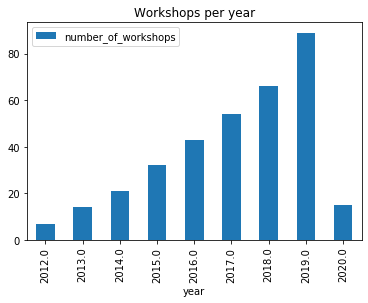

In [13]:
# How many workshops are there for each year?
workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

workshop_type  DC  LC  SWC  TTT
year                           
2012.0          0   0    7    0
2013.0          0   0   14    0
2014.0          0   0   21    0
2015.0          2   1   25    4
2016.0          7   0   30    3
2017.0         12   2   33    4
2018.0         13   2   46    1
2019.0         26   3   56    3
2020.0          2   1   11    1


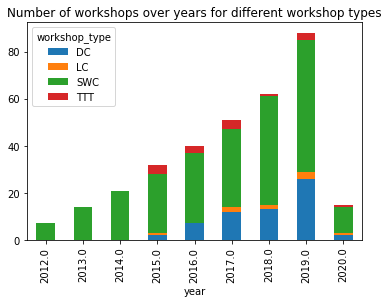

In [14]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

               number_of_workshops
workshop_type                     
SWC                            249
DC                              64
TTT                             16
LC                              11


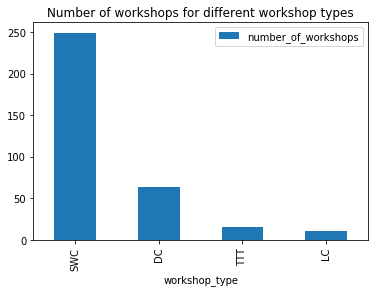

In [15]:
# How many of SWC, DC, LC, TTT workshops each were held so far?
workshops_per_type = workshops_df['workshop_type'].value_counts()
workshops_per_type.index.name = 'workshop_type'
workshops_per_type = workshops_per_type.to_frame('number_of_workshops')
print(workshops_per_type)
workshops_per_type.plot(kind='bar', legend=True, title ="Number of workshops for different workshop types")

workshop_type  DC  LC  SWC  TTT
year                           
2012.0          0   0    7    0
2013.0          0   0   14    0
2014.0          0   0   21    0
2015.0          2   1   25    4
2016.0          7   0   30    3
2017.0         12   2   33    4
2018.0         13   2   46    1
2019.0         26   3   56    3
2020.0          2   1   11    1


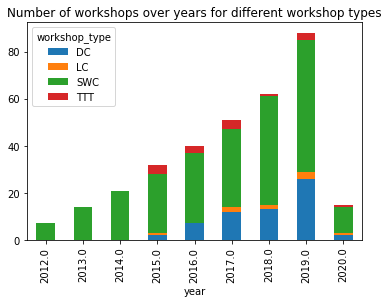

In [16]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

In [17]:
print(workshops_per_type_per_year.columns)

Index(['DC', 'LC', 'SWC', 'TTT'], dtype='object', name='workshop_type')


In [23]:
# Let's just look at Instructor Training workshops ("TTT")
workshops_df[workshops_df['workshop_type'] == 'TTT'][['slug', 'organiser']]

,slug,organiser
1,2020-05-28-ttt-edinburgh,SSI Software Sustainability Institute
30,2019-10-31-ttt-Imperial,Imperial College London
37,2019-10-08-ttt-manchester,University of Manchester
40,2019-09-25-ttt-leeds,University of Leeds
155,2018-04-18-ttt-leeds,University of Leeds
173,2017-12-05-ttt-southampton,University of Southampton
181,2017-10-30-imperial-ttt,Imperial College London
190,2017-09-04-ttt-manchester,University of Manchester
213,2017-03-16-ttt-oxford,University of Oxford
226,2016-11-24-ttt-metoffice,UK Met Office


ed.ac.uk                  35
ucl.ac.uk                 35
manchester.ac.uk          33
elixir-uk.org             24
imperial.ac.uk            23
leeds.ac.uk               19
ox.ac.uk                  18
southampton.ac.uk         14
cam.ac.uk                 12
st-andrews.ac.uk          11
bham.ac.uk                11
swansea.ac.uk             10
earlham.ac.uk             10
kcl.ac.uk                  9
aber.ac.uk                 6
dundee.ac.uk               5
anthro.ox.ac.uk            5
bristol.ac.uk              4
shef.ac.uk                 4
hw.ac.uk                   3
epcc.ed.ac.uk              3
tgac.ac.uk                 3
bradford.ac.uk             3
qmul.ac.uk                 3
crick.ac.uk                2
york.ac.uk                 2
nhm.ac.uk                  2
rhul.ac.uk                 2
sussex.ac.uk               2
qub.ac.uk                  2
                          ..
gla.ac.uk                  2
ncl.ac.uk                  2
bath.ac.uk                 2
exeter.ac.uk  

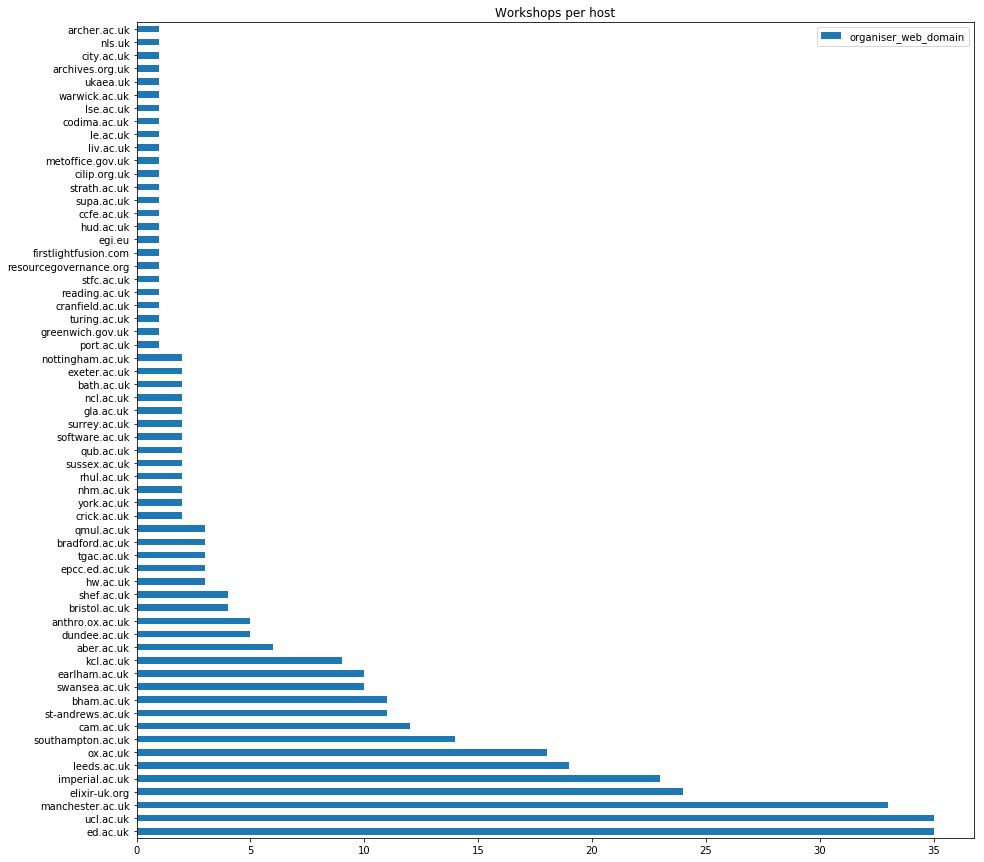

In [11]:
# How many workshops were held at each host institution?
workshops_per_host = workshops_df['organiser_web_domain'].value_counts()
print(workshops_per_host)
workshops_per_host.plot(kind='barh', legend=True, title ="Workshops per host", figsize = (15,15))

In [12]:
# How many workshops have been held at each instituion each year?
# Remove rows with NaN value for the institution
workshops_df = workshops_df.dropna(subset=['organiser_web_domain'])

workshops_per_host_per_year = pd.core.frame.DataFrame(
    {'number_of_workshops': workshops_df.groupby(['organiser_web_domain', 'year']).size()}).reset_index()
workshops_per_host_per_year_pivot = workshops_per_host_per_year.pivot_table(index='organiser_web_domain', columns='year')
workshops_per_host_per_year_pivot = workshops_per_host_per_year_pivot.fillna(0).astype('int')
workshops_per_host_per_year_pivot

number_of_workshops                                     \
year                                2012.0 2013.0 2014.0 2015.0 2016.0 2017.0   
organiser_web_domain                                                            
aber.ac.uk                               0      0      0      0      0      0   
anthro.ox.ac.uk                          0      0      0      0      0      4   
archer.ac.uk                             0      0      0      0      0      0   
archives.org.uk                          0      0      0      0      0      1   
bath.ac.uk                               0      1      0      0      0      0   
bham.ac.uk                               0      0      0      0      0      0   
bradford.ac.uk                           0      0      0      0      0      0   
bristol.ac.uk                            0      1      0      0      1      2   
cam.ac.uk                                0      0      2      2      2      2   
ccfe.ac.uk                               0      0      0      1      0      0   
city.ac.uk                               0      0      0      1      0      0   
codima.ac.uk                             0      0      0      0      0      0   
cranfield.ac.uk                          0      0      1      0      0      0   
crick.ac.uk                              0      0      0      0      0      2   
dundee.ac.uk                             0      1      0      0      1      1   
earlham.ac.uk                            0      0      0      0      1      3   
ed.ac.uk                                 1      1      1      2      5      0   
egi.eu                                   0      1      0      0      0      0   
elixir-uk.org                            0      0      0      0      0      0   
epcc.ed.ac.uk                            0      0      0      0      1      2   
exeter.ac.uk                             0      1      0      0      0      1   
gla.ac.uk                                0      0      1      0      0      1   
greenwich.gov.uk                         0      1      0      0      0      0   
hud.ac.uk                                0      0      0      0      1      0   
hw.ac.uk                                 0      0      0      0      0      0   
imperial.ac.uk                           0      0      2      3      1      5   
kcl.ac.uk                                0      0      0      0      0      0   
le.ac.uk                                 0      0      0      0      0      0   
leeds.ac.uk                              0      0      1      5      8      3   
liv.ac.uk                                0      0      1      0      0      0   
lse.ac.uk                                0      0      0      0      0      0   
manchester.ac.uk                         0      1      3      5      2      5   
metoffice.gov.uk                         0      0      0      0      1      0   
ncl.ac.uk                                2      0      0      0      0      0   
nhm.ac.uk                                0      0      0      0      2      0   
nls.uk                                   0      0      0      0      0      0   
nottingham.ac.uk                         0      0      1      0      1      0   
ox.ac.uk                                 1      1      0      3      3      2   
port.ac.uk                               0      0      0      1      0      0   
qmul.ac.uk                               0      1      0      0      0      1   
qub.ac.uk                                0      0      0      0      1      1   
reading.ac.uk                            0      0      1      0      0      0   
resourcegovernance.org                   0      0      0      0      1      0   
rhul.ac.uk                               0      0      0      1      1      0   
shef.ac.uk                               0      0      0      0      0      3   
software.ac.uk                           0      0      0      0      0      0   
southampton.ac.uk                        0      1     

year
2012.0     228
2013.0     439
2014.0     509
2015.0     898
2016.0     839
2017.0    1126
2018.0     921
2019.0     771
2020.0      25
Name: attendance, dtype: int64


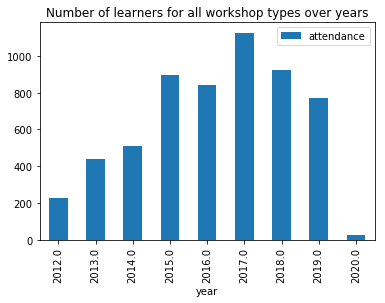

In [13]:
# How many learners attended workshops over years?
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().fillna(0).astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Number of learners for all workshop types over years")

Average workshop attendance: 16

year
2012.0     228
2013.0     439
2014.0     509
2015.0     898
2016.0     839
2017.0    1126
2018.0     921
2019.0     771
2020.0      25
Name: attendance, dtype: int64


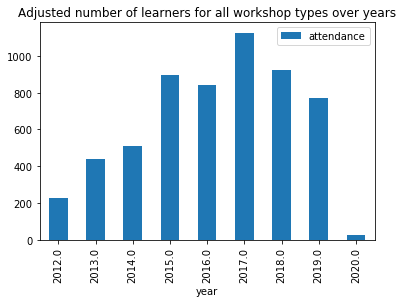

In [14]:
# How many learners attended workshops over years (with adjustments for missing attendance data with average attendance)?

# Disregard TTT workshops as they have attendance capped at 20 most of the times
average_attendance = round(workshops_df[workshops_df["workshop_type"] != "TTT"]["attendance"].mean())
print("Average workshop attendance: " + str(average_attendance) + "\n")
# Adjusted attendance over year data and graph
workshops_df["attendance"].fillna(average_attendance, inplace=True)
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Adjusted number of learners for all workshop types over years")

workshop_type
DC      947
LC      164
SWC    4420
TTT     225
Name: attendance, dtype: int64


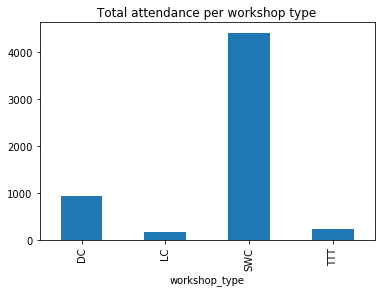

In [15]:
# Total attendance for different workshop types (with missing data adjusted with average attendance)
attendance_per_type = workshops_df.groupby(['workshop_type'])['attendance'].sum().astype("int")
print(attendance_per_type)
attendance_per_type.plot(kind="bar", title="Total attendance per workshop type")

workshop_type   DC  LC  SWC  TTT
year                            
2012.0           0   0  228    0
2013.0           0   0  439    0
2014.0           0   0  509    0
2015.0          78  59  686   75
2016.0         144   0  635   60
2017.0         284  51  706   85
2018.0         156  54  706    5
2019.0         285   0  486    0
2020.0           0   0   25    0


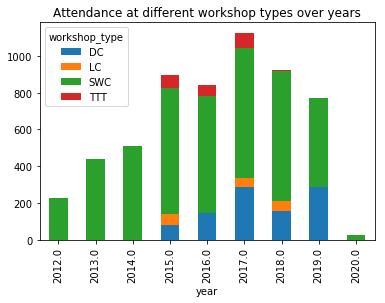

In [16]:
# How many learners attended each of (SWC, DC, LC, TTT) workshops over years (missing data adjusted by average attendance)?
attendance_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['attendance'].sum().unstack("workshop_type").fillna(0).astype("int")
print(attendance_per_type_per_year)
attendance_per_type_per_year.plot(kind='bar', stacked=True, title="Attendance at different workshop types over years")


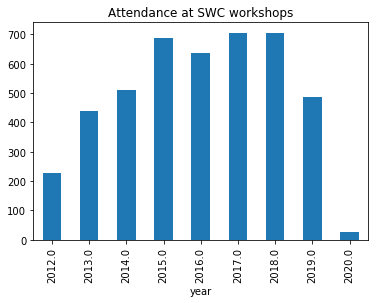

In [17]:
# Attendance just for SWC workshops over years
# Can be done similarly for DC, LC, TTT workshops, this is just an example
attendance_per_type_per_year["SWC"].plot(kind='bar', title="Attendance at SWC workshops")

                          number_of_workshops
region                                       
London                                     72
Scotland                                   55
South East                                 42
North West                                 32
Yorkshire and The Humber                   26
Eastern                                    24
Wales                                      15
West Midlands                              11
South West                                  8
East Midlands                               6
North East                                  3
Northern Ireland                            2


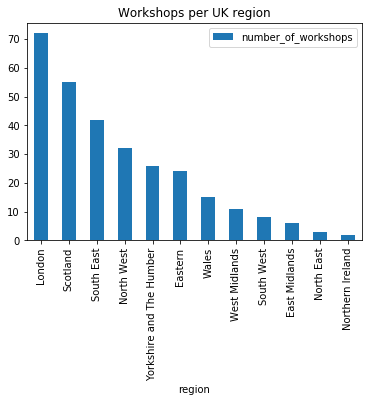

In [18]:
# How many workshops per UK regions?
workshops_per_UK_region = workshops_df['region'].value_counts()
workshops_per_UK_region.index.name = 'region'
workshops_per_UK_region = workshops_per_UK_region.to_frame('number_of_workshops')
print(workshops_per_UK_region)
workshops_per_UK_region.plot(kind='bar', legend=True, title ="Workshops per UK region")

In [22]:
# Let's do a choropleth map of workshops per UK regions
# uk_regions = json.load(open(UK_REGIONS_FILE, encoding='utf-8-sig'))
# workshops_map = helper.generate_choropleth_map(workshops_df[~workshops_df['region'].isnull()], uk_regions, "workshops")
# workshops_map

In [25]:
# Let's draw a clustered map of all workshop locations
workshops_map = helper.generate_map_with_clustered_markers(workshops_df[~workshops_df['longitude'].isnull()])
workshops_map

In [ ]:
# Save all analyses into an Excel spreadsheet
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

workshops_file_name = os.path.basename(workshops_file)
workshops_file_name_without_extension = re.sub('\.csv$', '', workshops_file_name.strip())
workshop_analyses_excel_file = ANALYSES_DIR + "analysed_" + workshops_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(workshop_analyses_excel_file, engine='xlsxwriter')

workshops_df.to_excel(excel_writer, sheet_name="carpentry_workshops", index=False)

# Workshops per year
workshops_per_year.to_excel(excel_writer, sheet_name='workshops_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(workshops_per_year.index), 0],
        'values': ['workshops_per_year', 1, 1, len(workshops_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per year'})
worksheet.insert_chart('I2', chart)

# Workshops per type   
workshops_per_type.to_excel(excel_writer, sheet_name='workshops_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_type', 1, 0, len(workshops_per_type.index), 0],
        'values': ['workshops_per_type', 1, 1, len(workshops_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types'})
worksheet.insert_chart('I2', chart)
    
# Workshops per type per year
workshops_per_type_per_year.to_excel(excel_writer, sheet_name='workshops_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_year', 0, i],
            'categories': ['workshops_per_type_per_year', i, 0, len(workshops_per_type_per_year.index), 0],
            'values': ['workshops_per_type_per_year', 1, i, len(workshops_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types over years'})
worksheet.insert_chart('B20', chart)

# Workshops per host
workshops_per_host.to_excel(excel_writer, sheet_name='workshops_per_host', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_host']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_host', 1, 0, len(workshops_per_host.index), 0],
        'values': ['workshops_per_host', 1, 1, len(workshops_per_host.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per host'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per year
attendance_per_year.to_excel(excel_writer, sheet_name='attendance_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_year', 1, 0, len(attendance_per_year.index), 0],
        'values': ['attendance_per_year', 1, 1, len(attendance_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per year (with estimates for missing data)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type
attendance_per_type.to_excel(excel_writer, sheet_name='attendance_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_type', 1, 0, len(attendance_per_type.index), 0],
        'values': ['attendance_per_type', 1, 1, len(attendance_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per workshop type (with estimates for missing data)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type per year
attendance_per_type_per_year.to_excel(excel_writer, sheet_name='attendance_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(attendance_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['attendance_per_type_per_year', 0, i],
            'categories': ['attendance_per_type_per_year', i, 0, len(attendance_per_type_per_year.index), 0],
            'values': ['attendance_per_type_per_year', 1, i, len(attendance_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Attendance', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Attendance at workshops of different types over years (with estimates for missing data)'})
worksheet.insert_chart('B20', chart)

excel_writer.save()
print("Saved workshop analyses in " + workshop_analyses_excel_file)